In [98]:
import sys
!conda install --yes --prefix {sys.prefix} -c anaconda requests

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## In this notebook, we are creating neural networks and applying them to MNIST
#### It consists on black and white images of hand-drawn digits (between 0 and 9)
### Updated from https://pytorch.org/tutorials/beginner/nn_tutorial.html
###

In [99]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


### The dataset is in pickle format, so we load it
#### The arrays are in numpy format

In [100]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

#### Let's display a number from the dataset shall we?

(50000, 784)


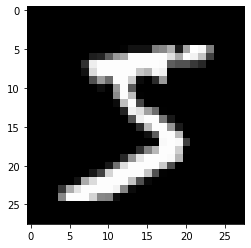

In [101]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


### We convert the numpy array to a Pytorch tensor,
### By using the torch.tensor command inside the "map" method

In [102]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# We build a Neural Net froms scratch <br /> 
We use the Xavier Initialization <br /> 
which consists in multiplying with 1/sqrt(n)) <br /> 


In [103]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

#This cell shows how to build and activation function with
#Pytorch

The second function is the model and the "@" stands for the dot product  <br /> 
That leads to an activation function.  <br /> 
Note that we start with random weights  <br /> 

In [104]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [105]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)


tensor([-3.0533, -2.0762, -1.7326, -2.3711, -2.2983, -2.3505, -2.4969, -2.7050,
        -1.9446, -2.6712], grad_fn=<SelectBackward>) torch.Size([64, 10])


### The tensor also contains a gradient function
### that will be later used for backpropagation

In [106]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [107]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

#We check our loss with our random model

yb = y_train[0:bs]
print(loss_func(preds, yb))


tensor([-3.0533, -2.0762, -1.7326, -2.3711, -2.2983, -2.3505, -2.4969, -2.7050,
        -1.9446, -2.6712], grad_fn=<SelectBackward>) torch.Size([64, 10])
tensor(2.4014, grad_fn=<NegBackward>)


In [108]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

#We check the accuracy of the random model,
#which is pretty low

tensor(0.0625)


### We run a training loop and for each iteration we will

(1) select a mini-batch of data (of size bs) <br /> 
(2) use the model to make predictions <br /> 
(3) calculate the loss <br /> 
(4) loss.backward() updates the gradients of the model, in this case, weights and bias <br /> 

In [109]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 10  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

### We now have a minimal neural net!!  
### Let's print out the loss and the accuracy


In [110]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0549, grad_fn=<NegBackward>) tensor(1.)


### Let's now take advantage of the torch neural net libraries via torch functional
### torch.nn.functional

It has a wide a range of loss and activation fuctions  <br />  
As well as ways to create its neural net

(1) select a mini-batch of data (of size bs) <br /> 
(2) F.cross_entropy allows for a convenient wayt to combine  <br /> 
    negative log likelihood loss and log softmax activation,

In [111]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [112]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0549, grad_fn=<NllLossBackward>) tensor(1.)


### Let's now explore the nn.Module
It allows to keep track of the weights, bias and methods  <br /> 
for the forward step  <br /> 
So we can update our parameters in a more concise way


In [113]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [114]:
#Let's instantiate our model

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

    

tensor(2.3585, grad_fn=<NllLossBackward>)


In [115]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()
print(loss_func(model(xb), yb))

tensor(0.0556, grad_fn=<NllLossBackward>)


With this model, our loss has gone significantly  <br />
down


## Let's now explore nn.linear
Applies a linear transformation to the incoming data forllowing this model: y = xA^T + b <br /> 
Precesily "xb  @ self.weights + self.bias"

In [116]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

#Instantiation of the model and calculation of the loss
model = Mnist_Logistic()
print(loss_func(model(xb), yb))
    

tensor(2.3718, grad_fn=<NllLossBackward>)


In [117]:
fit()

print("Our loss using the nn.linear model is ", loss_func(model(xb), yb))

Our loss using the nn.linear model is  tensor(0.0554, grad_fn=<NllLossBackward>)


### Let's take advantage of the optimization
We will use the "torch.optim" package  <br /> 
Thanks to that package we will go from : <br /> 

with torch.no_grad(): <br /> 
    for p in model.parameters(): p -= p.grad * lr <br /> 
    model.zero_grad() <br /> 
    
to just 2 lines of code!!: <br /> 
opt.step()  <br /> 
opt.zero_grad()  <br /> 


In [118]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3438, grad_fn=<NllLossBackward>)
tensor(0.0553, grad_fn=<NllLossBackward>)


## Let's use the Dataset class
(1) It comes with built-in method __len__(called by Python’s standard len function)  <br />
(2) and a __getitem__ function as a way of indexing into it.  <br />
(3) Both xtrain and ytrain will be combined as a single Tensor Dataset  <br />
    which makes it easier to iterate and slice  <br />
    
    
##############  <br />

Essentially:  <br />
xb = x_train[start_i:end_i]  <br />
yb = y_train[start_i:end_i]  <br />

becomes  <br />

xb,yb = train_ds[i*bs : i*bs+bs]  <br />

In [119]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

xb,yb = train_ds[i*bs : i*bs+bs]
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0554, grad_fn=<NllLossBackward>)


## We can also get the minibatch automatically
(1) It comes with built-in method __len__(called by Python’s standard len function)  <br />

    

In [120]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)


for xb,yb in train_dl:
    pred = model(xb)
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0556, grad_fn=<NllLossBackward>)


## Let's add the validation set to prevent the correlation between
batches and overfitting

In [121]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

## We print validation loss after each epoch


In [122]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2923)
1 tensor(0.2948)
2 tensor(0.2718)
3 tensor(0.2757)
4 tensor(0.2784)
5 tensor(0.2678)
6 tensor(0.2794)
7 tensor(0.3119)
8 tensor(0.2683)
9 tensor(0.2810)


### We calculating the loss for both the training set and the validation set,
## and create a loss function for each batch

In [123]:
import numpy as np


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

### We may now fit()


In [124]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3160462842941284
1 0.2942699025392532
2 0.2914047648489475
3 0.27732405828237533
4 0.28337413132190703
5 0.27754870800971987
6 0.2759702271938324
7 0.27281663073301315
8 0.30301346428394316
9 0.2936370015859604


## We may now switch to CNN in 2D
We will create 3 convolutional layers  <br />
We use ReLU as an activation fuction

In [125]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

## We take into account the momentum
which is a variation on stochastic gradient descent that  <br />
takes previous updates into account as well and generally leads to faster training.

In [126]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3326562440872192
1 0.2613667967557907
2 0.23306234071552753
3 0.18285769625902176
4 0.18630328620672226
5 0.1534605371236801
6 0.14499054169356823
7 0.14741806494891643
8 0.17534390926361085
9 0.13108132175803183


###  Let's use nn.Sequential
Sequential object runs each of the modules contained within it, <br />
in a sequential manner. It makes it simpler to write our neural network (NN)<br />

In [127]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)


model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.3805970980644226
1 0.2464430647134781
2 0.23881264120340348
3 0.24158590399324895
4 0.16752589990198613
5 0.1699852031648159
6 0.1422518071293831
7 0.13342807356119155
8 0.14889539048075676
9 0.14919606731235982


###  One thing with our CNN function to keep in mind is that:
(1) It assumes the input is a 28*28 long vector <br />
(2) It assumes that the final CNN grid size is 4*4 (since that’s the average <br />
    Sequential object runs each of the modules contained within it, <br />
#Let;'s define our module in a different way'

In [128]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

We essentially can replace "nn.AvgPool2d" with "nn.AdaptiveAvgPool2d" <br />
in order to  define the size of the output tensor we want <br />

In [129]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.5901534338951111
1 0.49427659039497374
2 0.4860578450202942
3 0.4295502504825592
4 0.4432272716999054
5 0.4297263397693634
6 0.4117113856315613
7 0.40519885873794553
8 0.39270885734558103
9 0.39931350069046023
